In [2]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import numpy as np 
# the number of clusters
n_clusters = 7
dataset = '151674'

# read data
file_fold = 'Data/DLPFC/' + str(dataset) 
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)

de_file = file_fold + '/devolution/predict_result.csv'
deconv_result = pd.read_csv(de_file, index_col=0)

adata.obsm['cell_type'] = deconv_result.values  


adata.var_names_make_unique()
adata


/home/lishenghe/anaconda3/envs/SGCD/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'cell_type'

In [3]:
from SGCD import SGCD 
import torch
# define model
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = SGCD.SGCD(adata, device=device,n=3,gama=0.1,random_seed = 44)

# train model
adata = model.train()
adata

Begin to train ST data...


100%|██████████| 600/600 [00:04<00:00, 139.73it/s]

Optimization finished for ST data!


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'cell_type', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [4]:
import os
import subprocess
from pathlib import Path
from SGCD.utils import clustering

try:
    r_path = subprocess.check_output(['which', 'R']).decode().strip()
    print(f"R is installed at: {r_path}")
except:
    print("R is not installed or not in PATH")

anaconda_path = str(Path.home()) + '/anaconda3/envs/SGCD/lib/R'
os.environ['R_HOME'] = anaconda_path

print(f"R_HOME set to: {os.environ['R_HOME']}")

# 3. Then proceed with your clustering code
radius = 50
clustering(adata, n_clusters, radius=radius, refinement=True)


R is installed at: /home/lishenghe/anaconda3/envs/SGCD/bin/R
R_HOME set to: /home/lishenghe/anaconda3/envs/SGCD/lib/R


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/lishenghe/anaconda3/envs/SGCD/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151674
ARI: 0.658617735718494
NMI: 0.7423573487460444


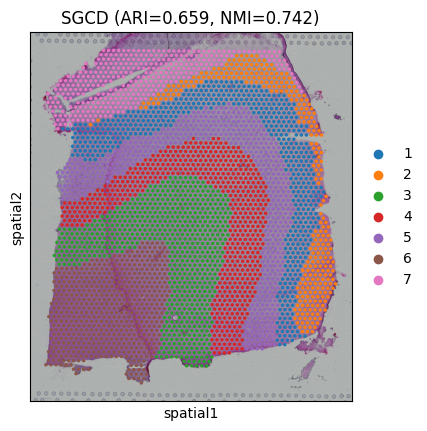

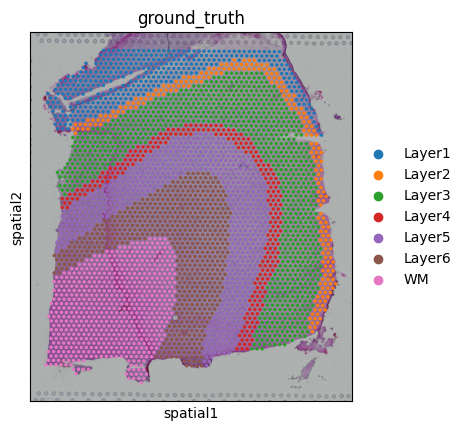

In [5]:
from sklearn import metrics


# 假设你已经加载了数据并且执行了以下操作：
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

# 过滤掉 ground_truth 中为 NA 的节点
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# 计算 ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

# 计算 NMI
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['NMI'] = NMI

# 打印 ARI 和 NMI
print('Dataset:', dataset)
print('ARI:', ARI)
print('NMI:', NMI)

import seaborn as sns
cmap = sns.color_palette("tab20", as_cmap=True)
#绘制空间聚类结果
sc.pl.spatial(adata,
              img_key="hires",
              color=[ "domain"],
              title=[ "SGCD (ARI=%.3f, NMI=%.3f)" % (ARI, NMI)],
              color_map=cmap,
              show=True)

sc.pl.spatial(adata,
              img_key="hires",
              color=[ "ground_truth"],
              show=True)


